<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bambi-notebook)=
# Syntactic Sugar

I modelli lineari sono utilizzati così ampiamente che sono stati sviluppati appositamente una sintassi, dei metodi e delle librerie per la regressione. Una di queste librerie è `bambi` (BAyesian Model-Building Interface). `bambi` è un pacchetto Python per adattare modelli gerarchici generalizzati lineari (di cui il modello lineaere bivariato è un caso particolare), utilizzando una sintassi simile a quella che si trova nei pacchetti R, come `lme4`, `nlme`, `rstanarm` o `brms`. `bambi` è basato su PyMC ma fornisce un'API di più alto livello. 

In questo capitolo vedremo come svolgere l'analisi di regressione usando `bambi` anziché PyMC.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bambi as bmb
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

Simuliamo i dati esattamente come abbiamo fatto nel capitolo precedente.

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

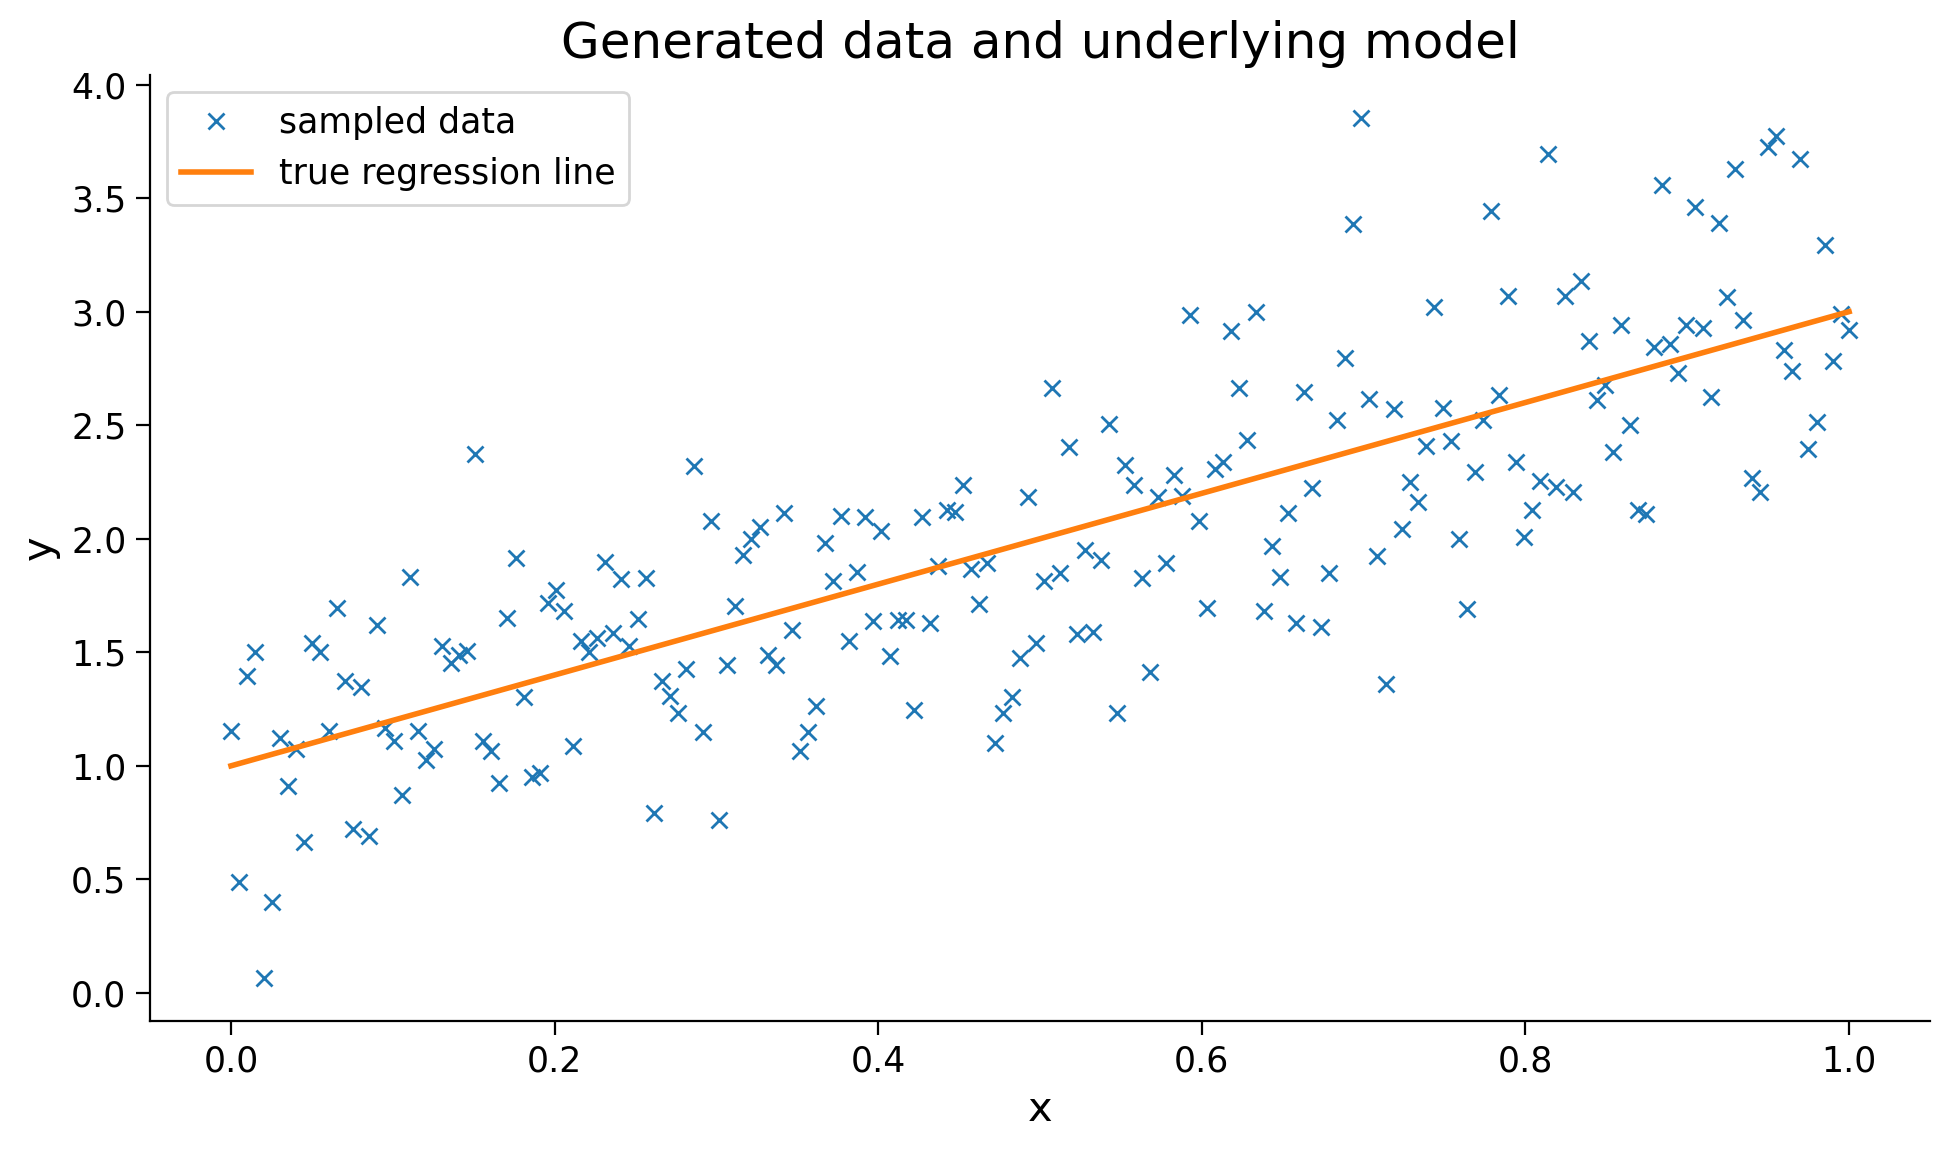

In [6]:
plt.figure(figsize=(10, 6))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated data and underlying model")
plt.plot(x, y, "x", label="sampled data")
plt.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

Per ottenere lo stesso modello descritto nel capitolo {ref}`reglin-pymc-notebook` usiamo l'istruzione seguente. `bambi` utilizza delle distribuzioni a priori "intelligenti" e dunque non abbiamo la necessità di specificarle in maniera esplicita. È tuttavia possibile farlo, se lo desideriamo. 

In [7]:
model = bmb.Model("y ~ x", data)

Eseguiamo il campionamento MCMC.

In [8]:
idata = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 18 seconds.


Le distribuzioni a posteriori dei parametri e i trace plot si ottengono con la seguente istruzione.

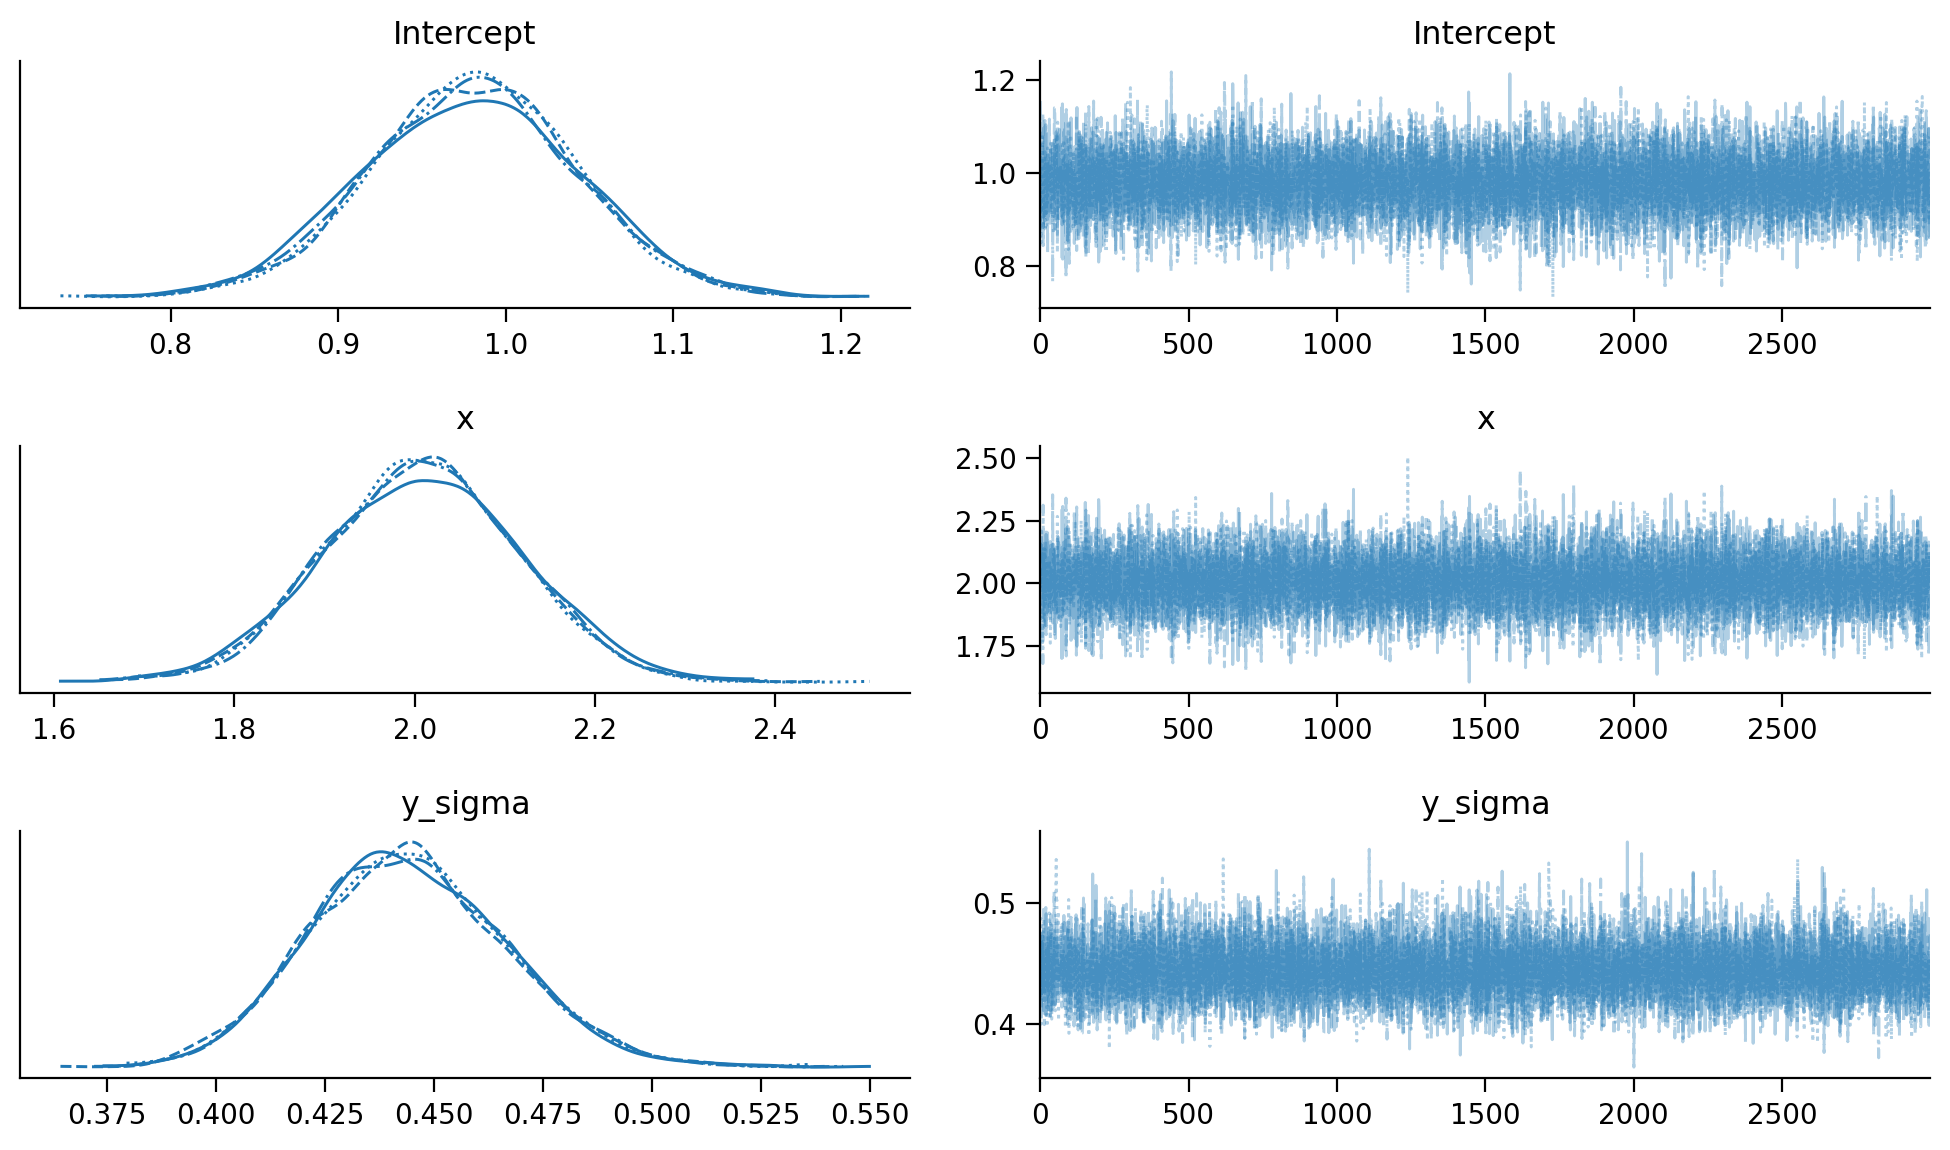

In [9]:
az.plot_trace(idata, figsize=(10, 6));

Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [10]:
az.summary(idata, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
Intercept,0.98,0.06,0.86,1.10
x,2.01,0.11,1.82,2.22
y_sigma,0.44,0.02,0.40,0.49


Si noti che i risultati replicano quelli ottenuti con PyMC.

Anche in questo caso è posibile generare un grafico che descrive l'incertezza a posteriori delle predizioni del modello. Un grafico predittivo a posteriori estrae più campioni dalla distribuzione a posteriori (intercette e pendenze) e traccia una retta di regressione per ciascuno di essi. Possiamo generare manualmente queste rette di regressione utilizzando direttamente i campioni a posteriori con l'istruzione seguente. Si noti che, usando `bambi`, il parametro $\alpha$ è denominato `Intercept`.

In [11]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

/Users/corrado/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


<Figure size 1000x600 with 0 Axes>

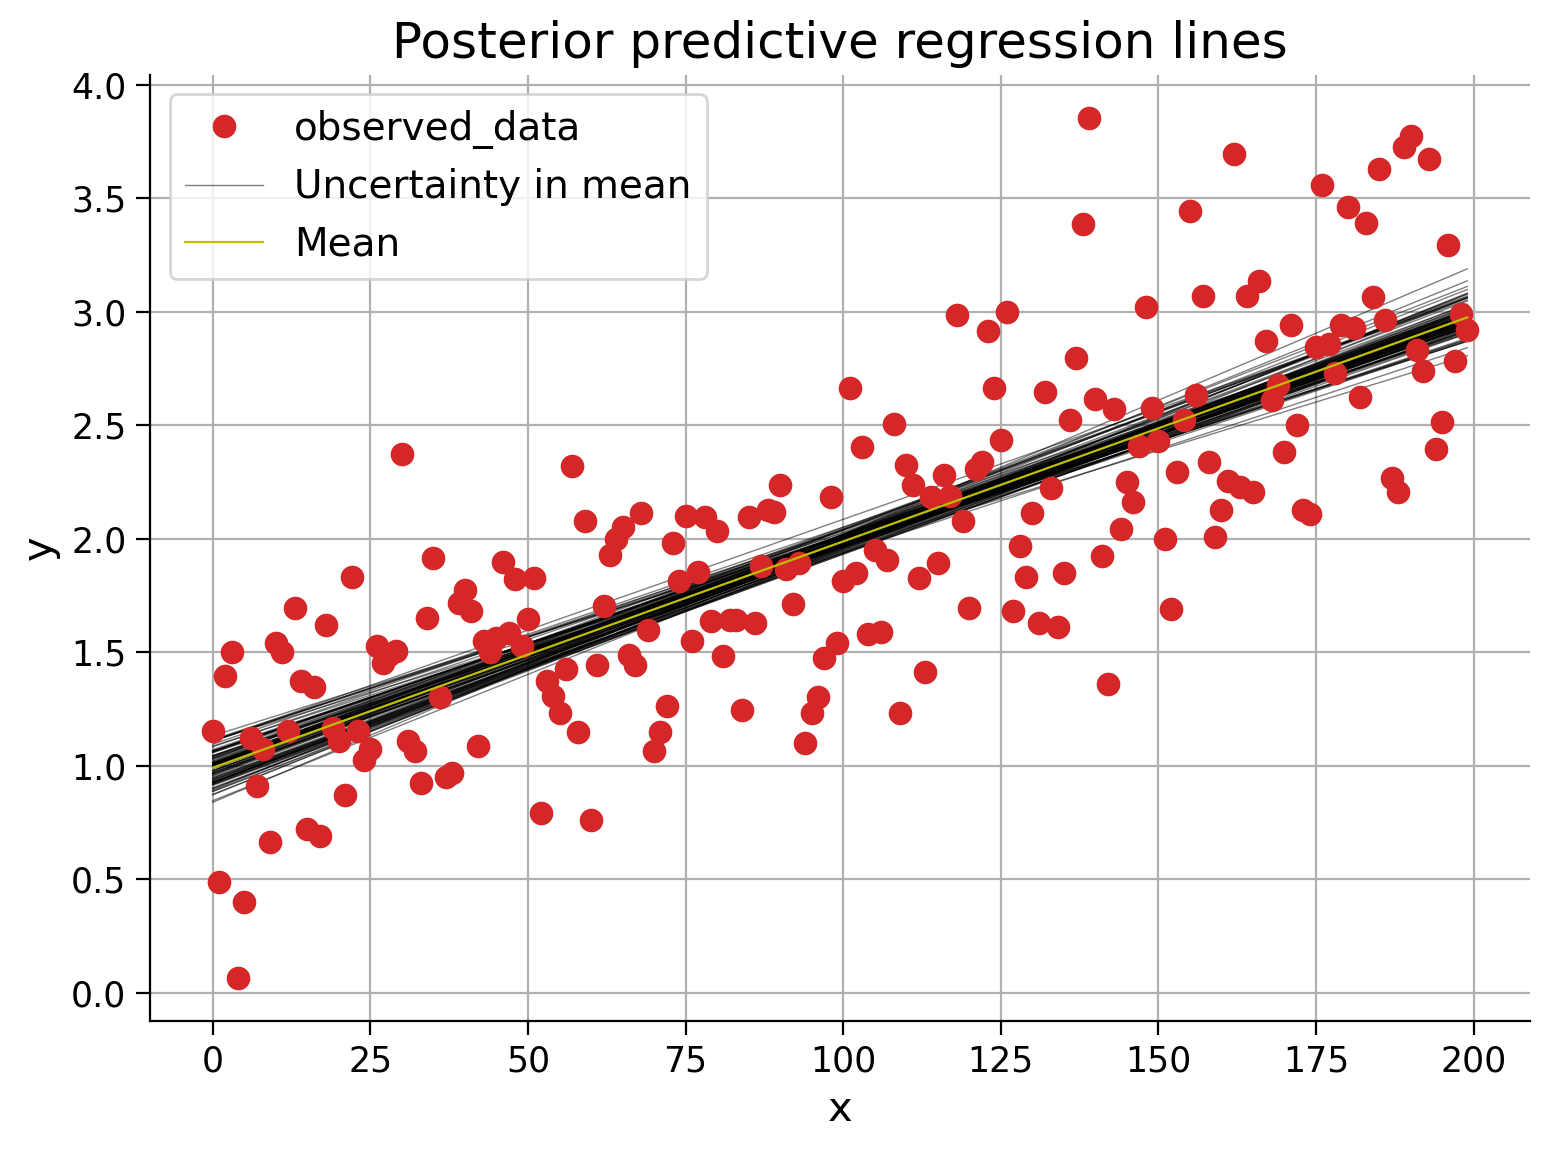

In [12]:
plt.figure(figsize=(10, 6))
az.plot_lm(idata=idata, y="y", num_samples=100, y_model="y_model")
plt.title("Posterior predictive regression lines")
plt.xlabel("x");

Come abbiamo già osservato in precedenza, le rette di regressione stimate si avvicinano notevolmente alla vera retta di regressione. Tuttavia, dato che stiamo lavorando con un campione di dati e non con l'intera popolazione, le stime dei parametri della retta di regressione, quali intercetta e pendenza, sono soggette a un certo grado di incertezza. Questa incertezza non è un difetto, ma una rappresentazione naturale dell'informazione limitata che abbiamo a disposizione, e nel grafico è visualizzata attraverso la variabilità delle rette di regressione.

## Watermark

In [49]:
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Aug 17 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

arviz     : 0.16.1
matplotlib: 3.7.1
bambi     : 0.12.0
numpy     : 1.25.2
pandas    : 2.0.3
xarray    : 2023.7.0
pymc      : 5.7.2

Watermark: 2.4.3

